In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from scipy.stats import skew, kurtosis

torch.cuda.empty_cache()
# imports of custom blocks for model, data generation
from Ferret.ImplicitAm import ImplicitAmBre, ImplicitAmBer
from create_plots import *
from models import *
from utils import AmericanCallData, get_prices_call
from utils import S, T, K, RISK_FREE, SIGMA, S_MAX

## Call Option

### Content: 
1. **Generating Data**
2. **Training on Generated Data, Testing Both on Generated and Real Data**
3. **Training on Real Data, Testing on Real Data**
4. **Mixture of Data (70/30, 50/50), Testing on Real Data**


In [ ]:
call_data = AmericanCallData(t_range=T, S_range=S, K=K, r=RISK_FREE, sigma=SIGMA)
# N_ivp - IVP points
# N_bvp - both BVP1 and BVP2 points
# N_col - colocation points
X = call_data.initialize_data(N_ivp=1000, N_bvp=3000, N_col=6000, is_call=True)
option = ImplicitAmBer(
    S[0],
    K,
    RISK_FREE,
    T[1],
    SIGMA,
    S_MAX,
    M=400,  # S
    N=365 * 3,  # t
    is_call=False,
)
option.price()
option_fde_prices = option.grid
data = get_prices_call(X, option_fde_prices, generated=True)
df = pd.DataFrame(
    data=data,
    columns=[
        "TimeToExp",
        "UnderlyingPrice",
        "TargetPrice",
        "OpenInterest",
        "Delta",
        "Gamma",
        "Theta",
        "Vega",
        "BSAprox",
    ],
)
df[["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]] = df[
    ["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]
].round(2)
df["OpenInterest"] = df["OpenInterest"].round(0)
df.to_csv("../train_data/generated_call.csv")

In [40]:
df = pd.read_csv("../train_data/generated_call.csv",index_col=0)
print(df.shape)
df.head()

(10000, 9)


,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,850.0,122.12,43.00,364.0,0.345992,0.144298,-3.575622,2.522842,31.500
1,311.0,186.19,29.31,514.0,0.167115,0.056784,-2.531811,6.822075,24.655
2,629.0,52.52,69.69,65.0,0.376269,0.272558,-7.814967,5.852912,0.000
3,469.0,144.80,37.75,58.0,0.009575,0.017516,-1.451383,1.604901,0.000
4,0.0,187.07,29.12,91.0,0.441506,0.138325,-8.777276,5.934998,118.970


In [3]:
# Check for ITM and OTM
print(f"ITM count:{np.sum(df.UnderlyingPrice > K)}")
print(f"OTM count:{np.sum(df.UnderlyingPrice <= K)}")

ITM count:4201
OTM count:5799


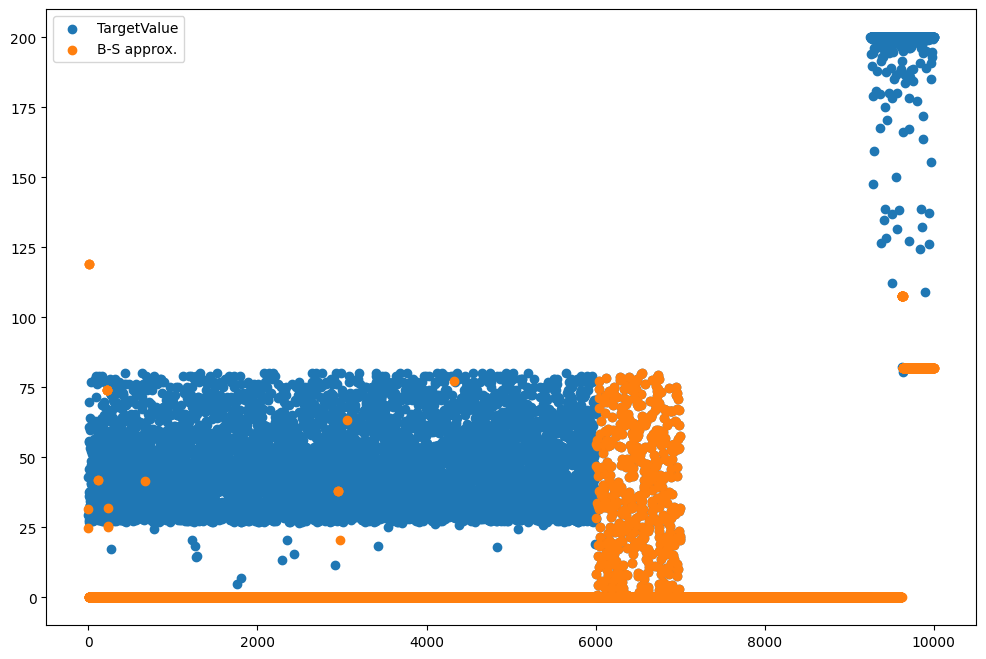

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(
    x=np.arange(1, len(df.TargetPrice) + 1, 1), y=df.TargetPrice, label="TargetValue"
)
plt.scatter(x=np.arange(1, len(df.BSAprox) + 1, 1), y=df.BSAprox, label="B-S approx.")
plt.legend()
plt.show()

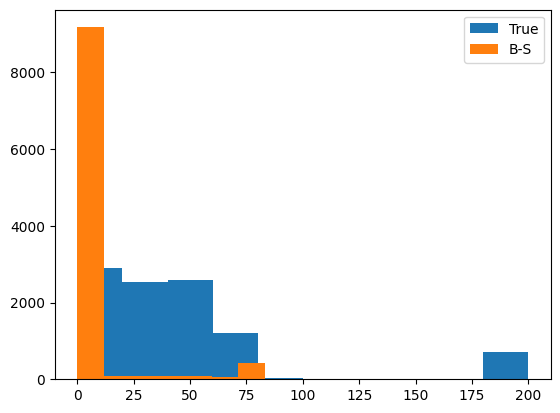

In [5]:
plt.hist(df.TargetPrice, label="Target value")
plt.hist(df.BSAprox, label="B-S")
plt.legend()
plt.show()

In [ ]:
# adding BSAprox column to real data
# Run it once, only if u dont have saved df
df_real = get_prices_call(df_real.to_numpy(), generated=False)
df_real = pd.DataFrame(
    data=df_real,
    columns=[
        [
            "UnderlyingPrice",
            "Type",
            "Strike",
            "OpenInterest",
            "IV",
            "Delta",
            "Gamma",
            "Theta",
            "Vega",
            "Time",
            "TargetPrice",
            "BSAprox",
        ]
    ],
)

df_real["BSAprox"] = df_real["BSAprox"].round(2)
df_real.to_csv("../train_data/call_df_with_approx.csv")

In [2]:
# df_real["BSAprox"] = df_real["BSAprox"].round(2)
# df_real.to_csv("../train_data/call_df_with_approx.csv")
df_real = pd.read_csv("../train_data/call_df_with_approx.csv", index_col=0)
df_real.head()

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
0,71.11,call,55.0,0,0.2693,1.0000,0.0000,-1.2654,0.0015,21,16.08,16.11
1,71.11,call,60.0,3,0.2693,0.9968,0.0022,-1.7664,0.1636,21,11.38,11.11
2,71.11,call,62.5,9,0.2693,0.9813,0.0101,-3.2537,0.7659,21,8.50,8.61
3,71.11,call,65.0,16,0.2693,0.9286,0.0302,-6.9022,2.2884,21,6.98,6.11
4,71.11,call,67.5,44,0.2430,0.8313,0.0617,-10.4813,4.2260,21,4.10,3.61


In [35]:
# hyperparams for training
N_EPOCH = 50
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 0.00075178
HIDDEN_LAYER = 24
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_call_13_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [36]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [37]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

cuda


In [38]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [41]:
# df = df_real.sample(n=20000, random_state=42)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_val.shape)

(8000, 9)
(2000, 9)


In [8]:
df_train

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
199175,118.42,call,75.0,0,0.1420,1.0000,0.0000,-1.7039,0.0003,175,43.70,43.42
2363,85.32,call,77.0,1,0.3000,1.0000,0.0000,0.0000,0.0000,0,8.48,8.32
176795,50.59,call,69.0,0,0.2779,0.2964,0.0183,-2.0880,23.4755,658,3.83,0.00
88593,87.16,call,71.0,0,0.0304,1.0000,0.0000,-1.6194,0.0000,112,16.08,16.16
114834,125.60,call,110.0,0,0.3586,0.8635,0.0133,-14.9743,9.9588,49,17.25,15.60
...,...,...,...,...,...,...,...,...,...,...,...,...
88793,87.16,call,80.0,0,0.0289,1.0000,0.0000,-1.8079,0.0042,259,7.10,7.16
23888,129.44,call,145.0,44,0.2264,0.0172,0.0061,-2.6030,1.2995,21,0.38,0.00
204990,41.37,call,175.0,37,0.4984,0.0000,0.0000,-0.0003,0.0004,140,0.05,0.00
86006,58.28,call,25.0,0,0.6706,0.9772,0.0013,0.0242,1.1421,140,33.45,33.28


In [42]:
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_val) * np.sum((df_val.TargetPrice - df_val.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)

In [43]:
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)

In [44]:
# import torch.multiprocessing as mp
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)
# from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
    "Adam": torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    "Adamax": torch.optim.Adamax(
        model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99)
    ),
}
criteriation = nn.MSELoss()

In [45]:
def check_data(dataloader):
    for batch_idx, data in enumerate(dataloader):
        inputs = data["input"]
        outputs = data["output"]
        if torch.isnan(inputs).any() or torch.isinf(inputs).any():
            print(f"NaN or Inf found in inputs at batch {batch_idx}")
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print(f"NaN or Inf found in outputs at batch {batch_idx}")

check_data(train_dataloader)
check_data(val_dataloader)


In [46]:
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()  # Step the scheduler
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the CosineAnnealingLR scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}"
        )


# def initialize_weights(model):
#     for layer in model.children():
#         if hasattr(layer, "weight") and layer.weight is not None:
#             nn.init.kaiming_normal_(
#                 layer.weight, mode="fan_in", nonlinearity="leaky_relu"
#             )


# model.apply(initialize_weights)

In [14]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import optuna
from optuna.trial import TrialState
from tqdm import tqdm


# Define the model
class AmericanPut_gated3(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(AmericanPut_gated3, self).__init__()
        self.N_HIDDEN = N_HIDDEN
        self.activation1 = nn.LeakyReLU(negative_slope=0.2)
        self.activation2 = nn.Tanh()
        self.fcs1 = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), self.activation2)
        self.fcs2 = nn.Sequential(nn.Linear(N_INPUT, N_OUTPUT), self.activation2)
        self.fch = nn.Sequential(
            *[
                nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), self.activation2)
                for _ in range(N_LAYERS)
            ]
        )
        self.fce = nn.Sequential(*[nn.Linear(N_HIDDEN, N_OUTPUT)])
        self.w1_layer = nn.Sequential(
            *[nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT), self.activation2]
        )
        # self.w2_layer = nn.Sequential(*[nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT),self.activation2])

    def forward(self, x):
        # Apply the first layer
        I1 = self.fcs1(x)
        H = I1
        # Apply hidden layers with residual connections
        for layer in self.fch:
            H = layer(H) + H
        # Apply the final layer
        yx = self.fcs2(x)  # 1D
        yh = self.fce(H)  # 1D
        h_x = torch.cat([H, x], axis=1)
        # print (h_x.shape)
        wh = self.w1_layer(h_x)
        y_net = yx + wh * yh
        return y_net


# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_width = trial.suggest_int("hidden_width", 32, 128)
    hidden_layers = trial.suggest_int("hidden_layers", 10, 30)
    learning_rate = trial.suggest_loguniform("learning_rate", 2e-8, 1e-1)
    optimizer_name = trial.suggest_categorical(
        "optimizer", ["SGD", "RMSprop", "Adam", "Adamax"]
    )
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    # Create the model
    model = AmericanPut_gated3(5, 1, hidden_width, hidden_layers).to(DEVICE)

    # Create the optimizer
    optimizers_list = {
        "SGD": torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7),
        "RMSprop": torch.optim.RMSprop(model.parameters(), lr=learning_rate),
        "Adam": torch.optim.Adam(model.parameters(), lr=learning_rate),
        "Adamax": torch.optim.Adamax(
            model.parameters(), lr=learning_rate, betas=(0.9, 0.99)
        ),
    }
    optimizer = optimizers_list[optimizer_name]

    # Define the ReduceLROnPlateau scheduler
    N_EPOCH = 10
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)
    # scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    criteriation = nn.MSELoss()

    # Create the dataloaders
    train_dataloader = DataLoader(
        train_df, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_df, batch_size=batch_size, shuffle=False, num_workers=8
    )

    # Training loop
    N_EPOCH = 10  # or some other number of epochs
    for epoch in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)

        # Report intermediate results to Optuna
        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss


# Run the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=600)

pruned_trials = [t for t in study.trials if t.state == TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]

print(f"Study statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

print(f"Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print(f"  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Use the best hyperparameters to train your final model
best_hidden_width = trial.params["hidden_width"]
best_hidden_layers = trial.params["hidden_layers"]
best_learning_rate = trial.params["learning_rate"]
best_optimizer_name = trial.params["optimizer"]
best_batch_size = trial.params["batch_size"]

/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-01 19:18:28,167] A new study created in memory with name: no-name-6a2669c5-76ed-4e94-b3a6-6a90da1e9140
/tmp/ipykernel_273131/874035944.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 2e-8, 1e-1)
100%|██████████| 8/8 [00:00<00:00, 138.78it/s]
[I 2024-06-01 19:18:38,304] Trial 0 finished with value: 3102.718780517578 and parameters: {'hidden_width': 75, 'hidden_layers': 26, 'learning_rate': 6.412594071060509e-07, 'optimizer': 'Adamax', 'batch_size': 256}. Best is trial 0 with value: 3102.718

Study statistics: 
  Number of finished trials: 30
  Number of pruned trials: 15
  Number of complete trials: 15
Best trial:
  Value: 1676.4805450439453
  Params: 
    hidden_width: 89
    hidden_layers: 13
    learning_rate: 0.008440304619980419
    optimizer: Adam
    batch_size: 64


In [47]:
train_loss_dict = {}
val_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, val_loss_dict)

Optimizer: SGD


100%|██████████| 32/32 [00:00<00:00, 234.35it/s]

Epoch 1, train loss: 33978.6318, val loss: 7541.3600



100%|██████████| 32/32 [00:00<00:00, 193.61it/s]

Epoch 2, train loss: 4670.4073, val loss: 3539.7367



100%|██████████| 32/32 [00:00<00:00, 201.04it/s]

Epoch 3, train loss: 2965.4831, val loss: 2683.6173



100%|██████████| 32/32 [00:00<00:00, 235.77it/s]

Epoch 4, train loss: 2501.0461, val loss: 2517.2730



100%|██████████| 32/32 [00:00<00:00, 220.61it/s]

Epoch 5, train loss: 2284.3642, val loss: 2363.4223



100%|██████████| 32/32 [00:00<00:00, 221.32it/s]

Epoch 6, train loss: 2269.9208, val loss: 2537.1974



100%|██████████| 32/32 [00:00<00:00, 181.49it/s]

Epoch 7, train loss: 2298.5690, val loss: 2454.1338



100%|██████████| 32/32 [00:00<00:00, 177.81it/s]

Epoch 8, train loss: 2280.7166, val loss: 2494.4259



100%|██████████| 32/32 [00:00<00:00, 195.21it/s]

Epoch 9, train loss: 2226.6197, val loss: 2452.9201



100%|██████████| 32/32 [00:00<00:00, 181.58it/s]

Epoch 10, train loss: 2247.2231, val loss: 2308.4700



100%|██████████| 32/32 [00:00<00:00, 186.01it/s]

Epoch 11, train loss: 2191.3770, val loss: 2303.1888



100%|██████████| 32/32 [00:00<00:00, 206.73it/s]

Epoch 12, train loss: 2151.0691, val loss: 2283.1307



100%|██████████| 32/32 [00:00<00:00, 222.18it/s]

Epoch 13, train loss: 2171.4402, val loss: 2185.3479



100%|██████████| 32/32 [00:00<00:00, 212.03it/s]

Epoch 14, train loss: 2223.1101, val loss: 2253.1397



100%|██████████| 32/32 [00:00<00:00, 212.10it/s]

Epoch 15, train loss: 2209.0477, val loss: 2336.7474



100%|██████████| 32/32 [00:00<00:00, 184.37it/s]

Epoch 16, train loss: 2215.1647, val loss: 2416.7592



100%|██████████| 32/32 [00:00<00:00, 188.11it/s]

Epoch 17, train loss: 2215.9643, val loss: 2192.7351



100%|██████████| 32/32 [00:00<00:00, 206.72it/s]

Epoch 18, train loss: 2203.4856, val loss: 2463.2537



100%|██████████| 32/32 [00:00<00:00, 189.45it/s]

Epoch 19, train loss: 2176.7527, val loss: 2303.2514



100%|██████████| 32/32 [00:00<00:00, 179.72it/s]

Epoch 20, train loss: 2188.1820, val loss: 2382.6728



100%|██████████| 32/32 [00:00<00:00, 192.36it/s]

Epoch 21, train loss: 2244.4789, val loss: 2347.2126



100%|██████████| 32/32 [00:00<00:00, 179.40it/s]

Epoch 22, train loss: 2246.3789, val loss: 2394.9221



100%|██████████| 32/32 [00:00<00:00, 193.80it/s]

Epoch 23, train loss: 2215.3490, val loss: 2352.0276



100%|██████████| 32/32 [00:00<00:00, 182.97it/s]

Epoch 24, train loss: 2231.9973, val loss: 2465.6559



100%|██████████| 32/32 [00:00<00:00, 206.80it/s]

Epoch 25, train loss: 2293.7304, val loss: 2367.0031



100%|██████████| 32/32 [00:00<00:00, 189.74it/s]

Epoch 26, train loss: 2193.7217, val loss: 2465.7302



100%|██████████| 32/32 [00:00<00:00, 195.38it/s]

Epoch 27, train loss: 2200.3842, val loss: 2325.7695



100%|██████████| 32/32 [00:00<00:00, 218.20it/s]

Epoch 28, train loss: 2176.0909, val loss: 2335.6858



100%|██████████| 32/32 [00:00<00:00, 189.36it/s]

Epoch 29, train loss: 2146.6544, val loss: 2273.3208



100%|██████████| 32/32 [00:00<00:00, 214.99it/s]

Epoch 30, train loss: 2159.2085, val loss: 2313.8913



100%|██████████| 32/32 [00:00<00:00, 203.40it/s]

Epoch 31, train loss: 2199.7221, val loss: 2320.1936



100%|██████████| 32/32 [00:00<00:00, 203.75it/s]

Epoch 32, train loss: 2207.7969, val loss: 2380.0764



100%|██████████| 32/32 [00:00<00:00, 203.56it/s]

Epoch 33, train loss: 2232.7749, val loss: 2542.6065



100%|██████████| 32/32 [00:00<00:00, 186.13it/s]

Epoch 34, train loss: 2284.1873, val loss: 2467.6335



100%|██████████| 32/32 [00:00<00:00, 216.30it/s]

Epoch 35, train loss: 2256.3098, val loss: 2466.2555



100%|██████████| 32/32 [00:00<00:00, 217.55it/s]

Epoch 36, train loss: 2228.7364, val loss: 2474.7901



100%|██████████| 32/32 [00:00<00:00, 217.08it/s]

Epoch 37, train loss: 2255.8094, val loss: 2434.3029



100%|██████████| 32/32 [00:00<00:00, 204.95it/s]

Epoch 38, train loss: 2247.7372, val loss: 2505.5405



100%|██████████| 32/32 [00:00<00:00, 202.55it/s]

Epoch 39, train loss: 2252.8323, val loss: 2482.3473



100%|██████████| 32/32 [00:00<00:00, 228.07it/s]

Epoch 40, train loss: 2250.1073, val loss: 2453.5441



100%|██████████| 32/32 [00:00<00:00, 192.75it/s]

Epoch 41, train loss: 2249.0037, val loss: 2396.5093



100%|██████████| 32/32 [00:00<00:00, 211.60it/s]

Epoch 42, train loss: 2221.1514, val loss: 2432.5548



100%|██████████| 32/32 [00:00<00:00, 193.63it/s]

Epoch 43, train loss: 2218.3549, val loss: 2427.5216



100%|██████████| 32/32 [00:00<00:00, 208.66it/s]

Epoch 44, train loss: 2223.1816, val loss: 2397.5437



100%|██████████| 32/32 [00:00<00:00, 199.69it/s]

Epoch 45, train loss: 2213.6623, val loss: 2377.3002



100%|██████████| 32/32 [00:00<00:00, 213.96it/s]

Epoch 46, train loss: 2204.3014, val loss: 2343.1897



100%|██████████| 32/32 [00:00<00:00, 218.88it/s]

Epoch 47, train loss: 2183.3742, val loss: 2365.8129



100%|██████████| 32/32 [00:00<00:00, 208.18it/s]

Epoch 48, train loss: 2189.8528, val loss: 2332.2966



100%|██████████| 32/32 [00:00<00:00, 221.89it/s]

Epoch 49, train loss: 2181.2418, val loss: 2338.6049



100%|██████████| 32/32 [00:00<00:00, 219.94it/s]

Epoch 50, train loss: 2177.8343, val loss: 2343.8155
Optimizer: RMSprop



100%|██████████| 32/32 [00:00<00:00, 180.49it/s]

Epoch 1, train loss: 2185.5655, val loss: 2329.5183



100%|██████████| 32/32 [00:00<00:00, 200.91it/s]

Epoch 2, train loss: 2165.6447, val loss: 2314.6339



100%|██████████| 32/32 [00:00<00:00, 185.19it/s]

Epoch 3, train loss: 2154.6373, val loss: 2321.2948



100%|██████████| 32/32 [00:00<00:00, 191.12it/s]

Epoch 4, train loss: 2148.8110, val loss: 2319.0806



100%|██████████| 32/32 [00:00<00:00, 204.62it/s]

Epoch 5, train loss: 2151.5936, val loss: 2324.3204



100%|██████████| 32/32 [00:00<00:00, 213.58it/s]

Epoch 6, train loss: 2138.4037, val loss: 2311.8177



100%|██████████| 32/32 [00:00<00:00, 192.70it/s]

Epoch 7, train loss: 2133.8231, val loss: 2327.7028



100%|██████████| 32/32 [00:00<00:00, 193.71it/s]

Epoch 8, train loss: 2132.6636, val loss: 2323.0651



100%|██████████| 32/32 [00:00<00:00, 195.95it/s]

Epoch 9, train loss: 2128.2706, val loss: 2323.6883



100%|██████████| 32/32 [00:00<00:00, 222.96it/s]

Epoch 10, train loss: 2127.7959, val loss: 2317.7407



100%|██████████| 32/32 [00:00<00:00, 206.64it/s]

Epoch 11, train loss: 2121.0123, val loss: 2316.7002



100%|██████████| 32/32 [00:00<00:00, 182.14it/s]

Epoch 12, train loss: 2120.0514, val loss: 2325.5922



100%|██████████| 32/32 [00:00<00:00, 209.11it/s]

Epoch 13, train loss: 2116.0591, val loss: 2311.2428



100%|██████████| 32/32 [00:00<00:00, 196.14it/s]

Epoch 14, train loss: 2115.0338, val loss: 2313.0310



100%|██████████| 32/32 [00:00<00:00, 213.05it/s]

Epoch 15, train loss: 2114.4213, val loss: 2316.6886



100%|██████████| 32/32 [00:00<00:00, 217.99it/s]

Epoch 16, train loss: 2105.8583, val loss: 2313.7722



100%|██████████| 32/32 [00:00<00:00, 210.53it/s]

Epoch 17, train loss: 2101.6593, val loss: 2319.1779



100%|██████████| 32/32 [00:00<00:00, 224.91it/s]

Epoch 18, train loss: 2096.7436, val loss: 2309.2723



100%|██████████| 32/32 [00:00<00:00, 200.89it/s]

Epoch 19, train loss: 2094.9283, val loss: 2311.2385



100%|██████████| 32/32 [00:00<00:00, 185.14it/s]

Epoch 20, train loss: 2089.4951, val loss: 2314.2388



100%|██████████| 32/32 [00:00<00:00, 228.02it/s]

Epoch 21, train loss: 2092.5310, val loss: 2310.8167



100%|██████████| 32/32 [00:00<00:00, 179.64it/s]

Epoch 22, train loss: 2090.5214, val loss: 2318.4568



100%|██████████| 32/32 [00:00<00:00, 203.18it/s]

Epoch 23, train loss: 2086.2841, val loss: 2308.5363



100%|██████████| 32/32 [00:00<00:00, 190.48it/s]

Epoch 24, train loss: 2081.4438, val loss: 2309.1041



100%|██████████| 32/32 [00:00<00:00, 209.57it/s]

Epoch 25, train loss: 2080.6326, val loss: 2318.3479



100%|██████████| 32/32 [00:00<00:00, 190.51it/s]

Epoch 26, train loss: 2076.2120, val loss: 2315.3213



100%|██████████| 32/32 [00:00<00:00, 203.79it/s]

Epoch 27, train loss: 2077.9227, val loss: 2316.5087



100%|██████████| 32/32 [00:00<00:00, 201.58it/s]

Epoch 28, train loss: 2076.6934, val loss: 2312.8404



100%|██████████| 32/32 [00:00<00:00, 225.40it/s]

Epoch 29, train loss: 2074.0470, val loss: 2311.6992



100%|██████████| 32/32 [00:00<00:00, 188.34it/s]

Epoch 30, train loss: 2072.0819, val loss: 2320.2955



100%|██████████| 32/32 [00:00<00:00, 183.60it/s]

Epoch 31, train loss: 2074.3229, val loss: 2317.1220



100%|██████████| 32/32 [00:00<00:00, 196.62it/s]

Epoch 32, train loss: 2070.6291, val loss: 2312.2657



100%|██████████| 32/32 [00:00<00:00, 198.95it/s]

Epoch 33, train loss: 2067.5084, val loss: 2309.6699



100%|██████████| 32/32 [00:00<00:00, 193.16it/s]

Epoch 34, train loss: 2064.0270, val loss: 2313.4968



100%|██████████| 32/32 [00:00<00:00, 233.25it/s]

Epoch 35, train loss: 2063.0871, val loss: 2312.9673



100%|██████████| 32/32 [00:00<00:00, 189.94it/s]

Epoch 36, train loss: 2061.7003, val loss: 2309.6899



100%|██████████| 32/32 [00:00<00:00, 203.72it/s]

Epoch 37, train loss: 2061.7617, val loss: 2311.6924



100%|██████████| 32/32 [00:00<00:00, 186.08it/s]

Epoch 38, train loss: 2061.8683, val loss: 2304.0207



100%|██████████| 32/32 [00:00<00:00, 190.15it/s]

Epoch 39, train loss: 2060.1972, val loss: 2308.7463



100%|██████████| 32/32 [00:00<00:00, 209.39it/s]

Epoch 40, train loss: 2058.1004, val loss: 2305.1755



100%|██████████| 32/32 [00:00<00:00, 174.81it/s]

Epoch 41, train loss: 2057.9392, val loss: 2305.6634



100%|██████████| 32/32 [00:00<00:00, 204.43it/s]

Epoch 42, train loss: 2058.1633, val loss: 2300.5522



100%|██████████| 32/32 [00:00<00:00, 159.22it/s]

Epoch 43, train loss: 2058.1942, val loss: 2301.7455



100%|██████████| 32/32 [00:00<00:00, 209.63it/s]

Epoch 44, train loss: 2056.4706, val loss: 2300.3898



100%|██████████| 32/32 [00:00<00:00, 198.17it/s]

Epoch 45, train loss: 2057.0569, val loss: 2301.6791



100%|██████████| 32/32 [00:00<00:00, 186.24it/s]

Epoch 46, train loss: 2054.7623, val loss: 2302.1789



100%|██████████| 32/32 [00:00<00:00, 188.99it/s]

Epoch 47, train loss: 2055.8218, val loss: 2302.4620



100%|██████████| 32/32 [00:00<00:00, 190.44it/s]

Epoch 48, train loss: 2055.1079, val loss: 2301.7325



100%|██████████| 32/32 [00:00<00:00, 183.53it/s]

Epoch 49, train loss: 2054.3263, val loss: 2302.6173



100%|██████████| 32/32 [00:00<00:00, 203.27it/s]

Epoch 50, train loss: 2054.7577, val loss: 2302.6440
Optimizer: Adam



100%|██████████| 32/32 [00:00<00:00, 185.75it/s]

Epoch 1, train loss: 2075.0707, val loss: 2314.2549



100%|██████████| 32/32 [00:00<00:00, 162.03it/s]


Epoch 2, train loss: 2093.9150, val loss: 2292.7338


100%|██████████| 32/32 [00:00<00:00, 168.54it/s]

Epoch 3, train loss: 2092.5388, val loss: 2328.6843



100%|██████████| 32/32 [00:00<00:00, 216.17it/s]

Epoch 4, train loss: 2087.1883, val loss: 2314.1110



100%|██████████| 32/32 [00:00<00:00, 183.13it/s]

Epoch 5, train loss: 2086.2329, val loss: 2322.4527



100%|██████████| 32/32 [00:00<00:00, 204.21it/s]

Epoch 6, train loss: 2083.1481, val loss: 2316.5881



100%|██████████| 32/32 [00:00<00:00, 203.27it/s]

Epoch 7, train loss: 2086.3921, val loss: 2319.1414



100%|██████████| 32/32 [00:00<00:00, 192.45it/s]

Epoch 8, train loss: 2079.0113, val loss: 2321.6042



100%|██████████| 32/32 [00:00<00:00, 203.09it/s]

Epoch 9, train loss: 2078.2524, val loss: 2318.3161



100%|██████████| 32/32 [00:00<00:00, 205.94it/s]

Epoch 10, train loss: 2082.9989, val loss: 2317.6477



100%|██████████| 32/32 [00:00<00:00, 211.53it/s]

Epoch 11, train loss: 2077.3358, val loss: 2317.3104



100%|██████████| 32/32 [00:00<00:00, 201.56it/s]

Epoch 12, train loss: 2074.5096, val loss: 2319.1544



100%|██████████| 32/32 [00:00<00:00, 194.03it/s]

Epoch 13, train loss: 2076.0448, val loss: 2309.8287



100%|██████████| 32/32 [00:00<00:00, 201.93it/s]

Epoch 14, train loss: 2069.9774, val loss: 2309.7568



100%|██████████| 32/32 [00:00<00:00, 89.86it/s]

Epoch 15, train loss: 2068.9881, val loss: 2314.5475



100%|██████████| 32/32 [00:00<00:00, 187.84it/s]

Epoch 16, train loss: 2066.0724, val loss: 2311.8645



100%|██████████| 32/32 [00:00<00:00, 190.85it/s]

Epoch 17, train loss: 2064.6744, val loss: 2309.4448



100%|██████████| 32/32 [00:00<00:00, 200.28it/s]

Epoch 18, train loss: 2064.0907, val loss: 2314.9269



100%|██████████| 32/32 [00:00<00:00, 184.72it/s]

Epoch 19, train loss: 2061.6530, val loss: 2314.4241



100%|██████████| 32/32 [00:00<00:00, 196.34it/s]

Epoch 20, train loss: 2061.1232, val loss: 2307.8659



100%|██████████| 32/32 [00:00<00:00, 201.59it/s]

Epoch 21, train loss: 2060.9829, val loss: 2304.9851



100%|██████████| 32/32 [00:00<00:00, 206.13it/s]

Epoch 22, train loss: 2058.4910, val loss: 2305.4233



100%|██████████| 32/32 [00:00<00:00, 214.77it/s]

Epoch 23, train loss: 2059.6950, val loss: 2296.8896



100%|██████████| 32/32 [00:00<00:00, 195.78it/s]

Epoch 24, train loss: 2059.3666, val loss: 2303.2692



100%|██████████| 32/32 [00:00<00:00, 231.58it/s]

Epoch 25, train loss: 2057.0942, val loss: 2302.4821



100%|██████████| 32/32 [00:00<00:00, 180.95it/s]

Epoch 26, train loss: 2054.9840, val loss: 2305.6305



100%|██████████| 32/32 [00:00<00:00, 211.36it/s]

Epoch 27, train loss: 2053.3508, val loss: 2296.8391



100%|██████████| 32/32 [00:00<00:00, 210.46it/s]

Epoch 28, train loss: 2051.9990, val loss: 2301.3057



100%|██████████| 32/32 [00:00<00:00, 206.84it/s]

Epoch 29, train loss: 2049.9847, val loss: 2297.2571



100%|██████████| 32/32 [00:00<00:00, 210.22it/s]

Epoch 30, train loss: 2049.9069, val loss: 2304.2285



100%|██████████| 32/32 [00:00<00:00, 179.22it/s]

Epoch 31, train loss: 2047.6093, val loss: 2305.0038



100%|██████████| 32/32 [00:00<00:00, 177.26it/s]

Epoch 32, train loss: 2047.0760, val loss: 2307.0209



100%|██████████| 32/32 [00:00<00:00, 222.06it/s]

Epoch 33, train loss: 2045.7451, val loss: 2305.6578



100%|██████████| 32/32 [00:00<00:00, 185.02it/s]

Epoch 34, train loss: 2044.8883, val loss: 2301.3762



100%|██████████| 32/32 [00:00<00:00, 195.61it/s]

Epoch 35, train loss: 2043.9151, val loss: 2304.0649



100%|██████████| 32/32 [00:00<00:00, 203.89it/s]

Epoch 36, train loss: 2042.1132, val loss: 2304.2932



100%|██████████| 32/32 [00:00<00:00, 197.80it/s]

Epoch 37, train loss: 2041.8405, val loss: 2304.0518



100%|██████████| 32/32 [00:00<00:00, 202.75it/s]

Epoch 38, train loss: 2041.9502, val loss: 2302.6123



100%|██████████| 32/32 [00:00<00:00, 208.11it/s]

Epoch 39, train loss: 2041.5369, val loss: 2304.5182



100%|██████████| 32/32 [00:00<00:00, 183.35it/s]

Epoch 40, train loss: 2042.1694, val loss: 2302.7307



100%|██████████| 32/32 [00:00<00:00, 203.49it/s]

Epoch 41, train loss: 2040.8371, val loss: 2303.0438



100%|██████████| 32/32 [00:00<00:00, 183.70it/s]

Epoch 42, train loss: 2040.3228, val loss: 2302.0664



100%|██████████| 32/32 [00:00<00:00, 225.91it/s]

Epoch 43, train loss: 2040.0181, val loss: 2301.3938



100%|██████████| 32/32 [00:00<00:00, 188.35it/s]

Epoch 44, train loss: 2039.6256, val loss: 2301.6901



100%|██████████| 32/32 [00:00<00:00, 194.77it/s]

Epoch 45, train loss: 2039.4628, val loss: 2302.0378



100%|██████████| 32/32 [00:00<00:00, 207.73it/s]

Epoch 46, train loss: 2039.3035, val loss: 2302.0756



100%|██████████| 32/32 [00:00<00:00, 215.42it/s]

Epoch 47, train loss: 2039.1656, val loss: 2302.2287



100%|██████████| 32/32 [00:00<00:00, 194.45it/s]

Epoch 48, train loss: 2039.0822, val loss: 2302.1043



100%|██████████| 32/32 [00:00<00:00, 202.63it/s]

Epoch 49, train loss: 2039.0359, val loss: 2302.0815



100%|██████████| 32/32 [00:00<00:00, 177.06it/s]

Epoch 50, train loss: 2039.0140, val loss: 2302.0733
Optimizer: Adamax



100%|██████████| 32/32 [00:00<00:00, 214.13it/s]

Epoch 1, train loss: 2045.8564, val loss: 2306.2714



100%|██████████| 32/32 [00:00<00:00, 239.15it/s]

Epoch 2, train loss: 2044.1080, val loss: 2312.8131



100%|██████████| 32/32 [00:00<00:00, 217.38it/s]

Epoch 3, train loss: 2042.5492, val loss: 2311.9457



100%|██████████| 32/32 [00:00<00:00, 201.76it/s]

Epoch 4, train loss: 2039.8911, val loss: 2311.4402



100%|██████████| 32/32 [00:00<00:00, 184.43it/s]

Epoch 5, train loss: 2039.5476, val loss: 2310.7724



100%|██████████| 32/32 [00:00<00:00, 221.06it/s]

Epoch 6, train loss: 2037.2588, val loss: 2311.8480



100%|██████████| 32/32 [00:00<00:00, 206.20it/s]

Epoch 7, train loss: 2036.2523, val loss: 2316.6422



100%|██████████| 32/32 [00:00<00:00, 191.99it/s]

Epoch 8, train loss: 2035.8271, val loss: 2317.0468



100%|██████████| 32/32 [00:00<00:00, 185.33it/s]

Epoch 9, train loss: 2033.8035, val loss: 2320.8504



100%|██████████| 32/32 [00:00<00:00, 207.64it/s]

Epoch 10, train loss: 2031.5093, val loss: 2316.4633



100%|██████████| 32/32 [00:00<00:00, 208.53it/s]

Epoch 11, train loss: 2031.5490, val loss: 2319.5173



100%|██████████| 32/32 [00:00<00:00, 202.18it/s]

Epoch 12, train loss: 2029.1074, val loss: 2319.0525



100%|██████████| 32/32 [00:00<00:00, 200.52it/s]

Epoch 13, train loss: 2029.3183, val loss: 2322.6059



100%|██████████| 32/32 [00:00<00:00, 185.48it/s]

Epoch 14, train loss: 2028.7958, val loss: 2314.6209



100%|██████████| 32/32 [00:00<00:00, 194.92it/s]

Epoch 15, train loss: 2026.7063, val loss: 2318.1183



100%|██████████| 32/32 [00:00<00:00, 208.19it/s]

Epoch 16, train loss: 2029.5784, val loss: 2321.7333



100%|██████████| 32/32 [00:00<00:00, 167.55it/s]

Epoch 17, train loss: 2024.8593, val loss: 2319.9922



100%|██████████| 32/32 [00:00<00:00, 186.25it/s]

Epoch 18, train loss: 2027.2435, val loss: 2318.4910



100%|██████████| 32/32 [00:00<00:00, 192.87it/s]

Epoch 19, train loss: 2024.5612, val loss: 2315.2854



100%|██████████| 32/32 [00:00<00:00, 208.13it/s]

Epoch 20, train loss: 2025.9309, val loss: 2315.0347



100%|██████████| 32/32 [00:00<00:00, 194.48it/s]

Epoch 21, train loss: 2023.9233, val loss: 2319.1277



100%|██████████| 32/32 [00:00<00:00, 184.48it/s]

Epoch 22, train loss: 2024.5980, val loss: 2320.2264



100%|██████████| 32/32 [00:00<00:00, 209.93it/s]

Epoch 23, train loss: 2022.0110, val loss: 2320.3293



100%|██████████| 32/32 [00:00<00:00, 207.83it/s]

Epoch 24, train loss: 2022.3490, val loss: 2319.2614



100%|██████████| 32/32 [00:00<00:00, 194.96it/s]

Epoch 25, train loss: 2022.8892, val loss: 2321.0189



100%|██████████| 32/32 [00:00<00:00, 185.00it/s]

Epoch 26, train loss: 2021.2435, val loss: 2319.8235



100%|██████████| 32/32 [00:00<00:00, 202.52it/s]

Epoch 27, train loss: 2021.8251, val loss: 2319.6781



100%|██████████| 32/32 [00:00<00:00, 199.84it/s]

Epoch 28, train loss: 2021.2388, val loss: 2320.2923



100%|██████████| 32/32 [00:00<00:00, 208.37it/s]

Epoch 29, train loss: 2021.0432, val loss: 2318.4139



100%|██████████| 32/32 [00:00<00:00, 206.91it/s]

Epoch 30, train loss: 2018.8623, val loss: 2317.4724



100%|██████████| 32/32 [00:00<00:00, 198.37it/s]

Epoch 31, train loss: 2018.1801, val loss: 2317.4435



100%|██████████| 32/32 [00:00<00:00, 214.39it/s]

Epoch 32, train loss: 2017.2159, val loss: 2316.4819



100%|██████████| 32/32 [00:00<00:00, 167.57it/s]

Epoch 33, train loss: 2018.5933, val loss: 2313.6823



100%|██████████| 32/32 [00:00<00:00, 191.94it/s]

Epoch 34, train loss: 2017.0278, val loss: 2313.0088



100%|██████████| 32/32 [00:00<00:00, 201.44it/s]

Epoch 35, train loss: 2015.0422, val loss: 2310.0865



100%|██████████| 32/32 [00:00<00:00, 201.36it/s]

Epoch 36, train loss: 2015.0662, val loss: 2311.4295



100%|██████████| 32/32 [00:00<00:00, 197.80it/s]

Epoch 37, train loss: 2014.2960, val loss: 2314.1803



100%|██████████| 32/32 [00:00<00:00, 207.29it/s]

Epoch 38, train loss: 2014.2981, val loss: 2313.7100



100%|██████████| 32/32 [00:00<00:00, 187.51it/s]

Epoch 39, train loss: 2013.3552, val loss: 2312.4506



100%|██████████| 32/32 [00:00<00:00, 191.29it/s]

Epoch 40, train loss: 2012.7130, val loss: 2311.5917



100%|██████████| 32/32 [00:00<00:00, 209.69it/s]

Epoch 41, train loss: 2012.8019, val loss: 2310.8326



100%|██████████| 32/32 [00:00<00:00, 208.52it/s]

Epoch 42, train loss: 2012.7627, val loss: 2311.0259



100%|██████████| 32/32 [00:00<00:00, 150.65it/s]

Epoch 43, train loss: 2012.7848, val loss: 2310.7180



100%|██████████| 32/32 [00:00<00:00, 171.38it/s]

Epoch 44, train loss: 2012.3715, val loss: 2311.3914



100%|██████████| 32/32 [00:00<00:00, 198.33it/s]

Epoch 45, train loss: 2012.5458, val loss: 2310.9249



100%|██████████| 32/32 [00:00<00:00, 202.89it/s]

Epoch 46, train loss: 2012.4225, val loss: 2310.6219



100%|██████████| 32/32 [00:00<00:00, 184.07it/s]

Epoch 47, train loss: 2012.2497, val loss: 2310.6620



100%|██████████| 32/32 [00:00<00:00, 202.88it/s]

Epoch 48, train loss: 2012.1159, val loss: 2310.5783



100%|██████████| 32/32 [00:00<00:00, 196.37it/s]

Epoch 49, train loss: 2012.0290, val loss: 2310.5818



100%|██████████| 32/32 [00:00<00:00, 196.45it/s]

Epoch 50, train loss: 2012.0229, val loss: 2310.5834


In [52]:
import matplotlib.pyplot as plt


def plot_dictionaries(dict1, dict2, initial_train, initial_val, save_path=None):
    # Set global font size
    plt.rcParams.update(
        {"font.size": 22}
    )  # Twice as big as the default font size (default is usually 10 or 12)

    fig, axes = plt.subplots(1, 2, figsize=(22, 8))  # Create a figure with two subplots

    # Plot for dictionary 1
    for key, values in dict1.items():
        axes[0].plot(
            range(5, len(values) + 1), values[4:], label=key, marker="*"
        )  # Start from second element
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("MSE Loss")
        axes[0].set_title(f"Train losses, initial: {initial_train.round(2)}")
        axes[0].grid(True)

    # Plot for dictionary 2
    for key, values in dict2.items():
        axes[1].plot(range(5, len(values) + 1), values[4:], label=key, marker="*")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("MSE Loss")
        axes[1].set_title(f"Validation losses, initial: {initial_val.round(2)}")
        axes[1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

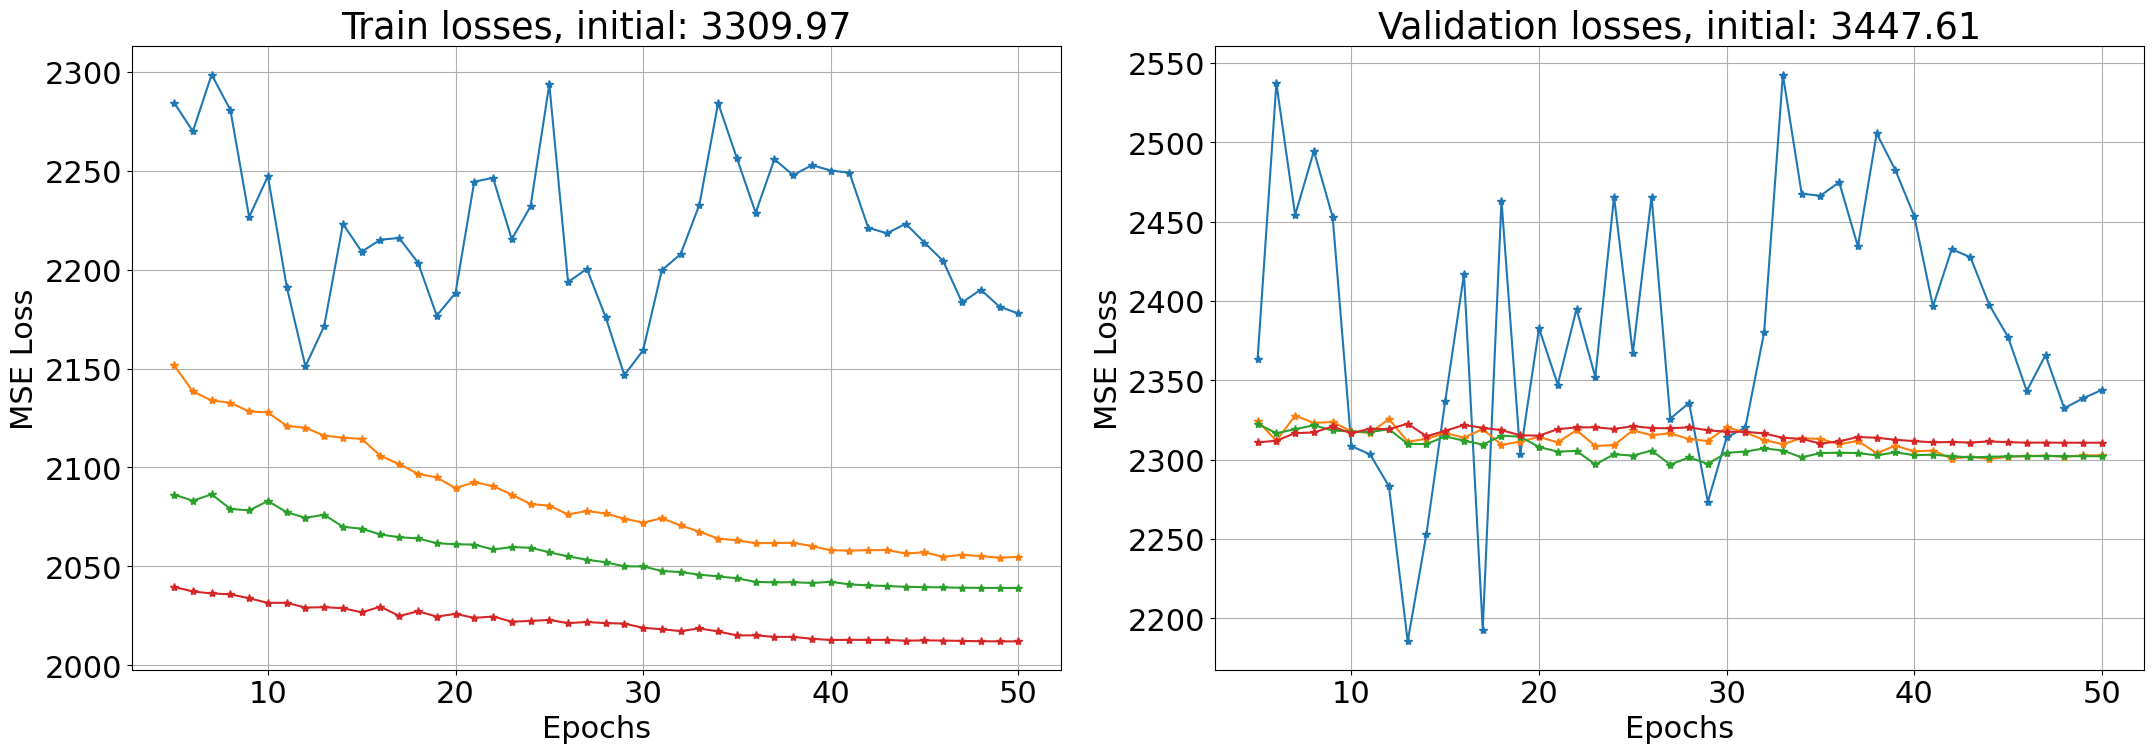

In [53]:
# Plot
plot_dictionaries(
    train_loss_dict,
    val_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_testing.png",
)

### So for full training we will take SGD, 20 layers with 256 neurouns in each and lr=4e-7

In [10]:
N_EPOCH = 100
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 0.00075178
HIDDEN_LAYER = 24
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_call_12_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [11]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [12]:
df

,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,850.00,122.12,43.00,364.0,0.345992,0.144298,-3.575622,2.522842,31.500
1,311.00,186.19,29.31,514.0,0.167115,0.056784,-2.531811,6.822075,24.655
2,629.00,52.52,69.69,65.0,0.376269,0.272558,-7.814967,5.852912,0.000
3,469.00,144.80,37.75,58.0,0.009575,0.017516,-1.451383,1.604901,0.000
4,0.00,187.07,29.12,91.0,0.441506,0.138325,-8.777276,5.934998,118.970
...,...,...,...,...,...,...,...,...,...
9995,1089.04,200.00,200.00,54.0,0.189853,0.083916,-31.967621,3.605873,82.030
9996,939.78,200.00,200.00,410.0,0.034537,0.091283,-10.788996,6.799438,82.030
9997,886.42,200.00,200.00,274.0,0.015381,0.324230,-4.528091,7.367978,82.030
9998,560.18,200.00,200.00,586.0,0.275679,0.402972,-4.144945,3.066105,82.030


In [19]:
df_train, df_test = train_test_split(df, test_size=0.2)
logging.info(f"train set size: {df_train.shape}")
logging.info(f"test set size: {df_test.shape}")
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = (
    1 / len(df_test) * np.sum((df_test.TargetPrice - df_test.BSAprox) ** 2)
)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)
train_df = CustomDataset(df_train)
test_df = CustomDataset(df_test)

In [20]:
# import torch.multiprocessing as mp
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_test)
# from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7)
}
criteriation = nn.MSELoss()

In [21]:
train_loss_dict = {}
test_loss_dict = {}
train_cycle("SGD", optimizers_list["SGD"], train_loss_dict, test_loss_dict, final=True)

Optimizer: SGD


100%|██████████| 32/32 [00:00<00:00, 221.76it/s]

Epoch 1, train loss: 179424.5565, val loss: 22292.7786



100%|██████████| 32/32 [00:00<00:00, 187.58it/s]

Epoch 2, train loss: 15658.3640, val loss: 9868.5977



100%|██████████| 32/32 [00:00<00:00, 208.37it/s]

Epoch 3, train loss: 7411.7368, val loss: 5025.5230



100%|██████████| 32/32 [00:00<00:00, 218.54it/s]

Epoch 4, train loss: 4738.0792, val loss: 3728.3216



100%|██████████| 32/32 [00:00<00:00, 258.19it/s]

Epoch 5, train loss: 3384.2485, val loss: 3149.2728



100%|██████████| 32/32 [00:00<00:00, 200.40it/s]

Epoch 6, train loss: 2899.4340, val loss: 2507.5801



100%|██████████| 32/32 [00:00<00:00, 179.74it/s]

Epoch 7, train loss: 2442.5778, val loss: 2435.9205



100%|██████████| 32/32 [00:00<00:00, 187.89it/s]

Epoch 8, train loss: 2339.8686, val loss: 2353.9158



100%|██████████| 32/32 [00:00<00:00, 204.69it/s]

Epoch 9, train loss: 2348.2816, val loss: 2421.6865



100%|██████████| 32/32 [00:00<00:00, 214.85it/s]

Epoch 10, train loss: 2227.5755, val loss: 2136.9100



100%|██████████| 32/32 [00:00<00:00, 191.01it/s]

Epoch 11, train loss: 2265.9626, val loss: 2179.0335



100%|██████████| 32/32 [00:00<00:00, 215.86it/s]

Epoch 12, train loss: 2194.6586, val loss: 2202.3683



100%|██████████| 32/32 [00:00<00:00, 244.71it/s]

Epoch 13, train loss: 2111.2919, val loss: 2280.9607



100%|██████████| 32/32 [00:00<00:00, 216.80it/s]

Epoch 14, train loss: 2053.5615, val loss: 2125.4968



100%|██████████| 32/32 [00:00<00:00, 222.46it/s]

Epoch 15, train loss: 2065.3654, val loss: 2062.1088



100%|██████████| 32/32 [00:00<00:00, 209.03it/s]

Epoch 16, train loss: 2085.5305, val loss: 2040.8024



100%|██████████| 32/32 [00:00<00:00, 177.88it/s]

Epoch 17, train loss: 2072.6498, val loss: 1983.2167



100%|██████████| 32/32 [00:00<00:00, 191.97it/s]

Epoch 18, train loss: 2032.3575, val loss: 2322.9572



100%|██████████| 32/32 [00:00<00:00, 158.93it/s]

Epoch 19, train loss: 2047.4378, val loss: 1986.6673



100%|██████████| 32/32 [00:00<00:00, 260.90it/s]

Epoch 20, train loss: 2078.3487, val loss: 2151.3989



100%|██████████| 32/32 [00:00<00:00, 222.50it/s]

Epoch 21, train loss: 2053.7355, val loss: 2340.1474



100%|██████████| 32/32 [00:00<00:00, 238.89it/s]

Epoch 22, train loss: 2073.6970, val loss: 2037.0937



100%|██████████| 32/32 [00:00<00:00, 228.05it/s]

Epoch 23, train loss: 2061.4475, val loss: 1951.8827



100%|██████████| 32/32 [00:00<00:00, 205.36it/s]

Epoch 24, train loss: 2078.8842, val loss: 1973.6584



100%|██████████| 32/32 [00:00<00:00, 229.69it/s]

Epoch 25, train loss: 2051.1678, val loss: 1980.9783



100%|██████████| 32/32 [00:00<00:00, 216.45it/s]

Epoch 26, train loss: 2042.8877, val loss: 2567.7831



100%|██████████| 32/32 [00:00<00:00, 216.90it/s]

Epoch 27, train loss: 2038.7763, val loss: 1925.3778



100%|██████████| 32/32 [00:00<00:00, 204.06it/s]

Epoch 28, train loss: 2040.7572, val loss: 1926.8217



100%|██████████| 32/32 [00:00<00:00, 224.92it/s]

Epoch 29, train loss: 2018.2526, val loss: 1965.8630



100%|██████████| 32/32 [00:00<00:00, 242.31it/s]

Epoch 30, train loss: 2015.3873, val loss: 1961.6819



100%|██████████| 32/32 [00:00<00:00, 264.39it/s]

Epoch 31, train loss: 2046.4722, val loss: 2041.8769



100%|██████████| 32/32 [00:00<00:00, 233.92it/s]

Epoch 32, train loss: 2024.0184, val loss: 2038.0982



100%|██████████| 32/32 [00:00<00:00, 234.27it/s]

Epoch 33, train loss: 2008.1091, val loss: 2018.4446



100%|██████████| 32/32 [00:00<00:00, 234.76it/s]

Epoch 34, train loss: 1989.1705, val loss: 1986.3183



100%|██████████| 32/32 [00:00<00:00, 245.44it/s]

Epoch 35, train loss: 2025.1578, val loss: 2047.5693



100%|██████████| 32/32 [00:00<00:00, 239.20it/s]

Epoch 36, train loss: 2021.7272, val loss: 2045.1949



100%|██████████| 32/32 [00:00<00:00, 247.52it/s]

Epoch 37, train loss: 2045.0793, val loss: 1961.7353



100%|██████████| 32/32 [00:00<00:00, 284.37it/s]

Epoch 38, train loss: 2001.8017, val loss: 1975.0072



100%|██████████| 32/32 [00:00<00:00, 234.72it/s]

Epoch 39, train loss: 2013.8809, val loss: 2158.3140



100%|██████████| 32/32 [00:00<00:00, 252.02it/s]

Epoch 40, train loss: 2027.3195, val loss: 2009.1905



100%|██████████| 32/32 [00:00<00:00, 225.61it/s]

Epoch 41, train loss: 1997.0971, val loss: 2354.5696



100%|██████████| 32/32 [00:00<00:00, 246.72it/s]

Epoch 42, train loss: 2034.8757, val loss: 2123.2350



100%|██████████| 32/32 [00:00<00:00, 259.21it/s]

Epoch 43, train loss: 1990.0233, val loss: 1989.3415



100%|██████████| 32/32 [00:00<00:00, 286.33it/s]

Epoch 44, train loss: 2010.4602, val loss: 2059.6829



100%|██████████| 32/32 [00:00<00:00, 239.39it/s]

Epoch 45, train loss: 2008.1973, val loss: 1994.8308



100%|██████████| 32/32 [00:00<00:00, 232.07it/s]

Epoch 46, train loss: 2030.6813, val loss: 1969.9869



100%|██████████| 32/32 [00:00<00:00, 197.82it/s]

Epoch 47, train loss: 2005.2987, val loss: 2017.3631



100%|██████████| 32/32 [00:00<00:00, 239.41it/s]

Epoch 48, train loss: 2022.6059, val loss: 2058.5246



100%|██████████| 32/32 [00:00<00:00, 240.53it/s]

Epoch 49, train loss: 1984.7106, val loss: 2174.5212



100%|██████████| 32/32 [00:00<00:00, 265.84it/s]

Epoch 50, train loss: 1976.9264, val loss: 1988.5604



100%|██████████| 32/32 [00:00<00:00, 223.61it/s]

Epoch 51, train loss: 1948.9563, val loss: 2040.0080



100%|██████████| 32/32 [00:00<00:00, 206.82it/s]

Epoch 52, train loss: 1968.7709, val loss: 1953.7519



100%|██████████| 32/32 [00:00<00:00, 216.18it/s]

Epoch 53, train loss: 1962.8403, val loss: 2006.6976



100%|██████████| 32/32 [00:00<00:00, 268.38it/s]

Epoch 54, train loss: 1952.8267, val loss: 2030.2729



100%|██████████| 32/32 [00:00<00:00, 234.34it/s]

Epoch 55, train loss: 1954.0239, val loss: 1996.1869



100%|██████████| 32/32 [00:00<00:00, 266.09it/s]

Epoch 56, train loss: 1953.9506, val loss: 2020.7288



100%|██████████| 32/32 [00:00<00:00, 241.88it/s]

Epoch 57, train loss: 1932.1221, val loss: 2047.9102



100%|██████████| 32/32 [00:00<00:00, 218.56it/s]

Epoch 58, train loss: 1934.1123, val loss: 2013.4671



100%|██████████| 32/32 [00:00<00:00, 204.57it/s]

Epoch 59, train loss: 1926.0906, val loss: 1974.9283



100%|██████████| 32/32 [00:00<00:00, 232.26it/s]

Epoch 60, train loss: 1932.9303, val loss: 2010.5182



100%|██████████| 32/32 [00:00<00:00, 267.25it/s]

Epoch 61, train loss: 1942.5612, val loss: 1967.3090



100%|██████████| 32/32 [00:00<00:00, 230.72it/s]

Epoch 62, train loss: 1935.5722, val loss: 1979.7742



100%|██████████| 32/32 [00:00<00:00, 231.82it/s]

Epoch 63, train loss: 1939.0327, val loss: 1990.8204



100%|██████████| 32/32 [00:00<00:00, 239.04it/s]

Epoch 64, train loss: 1933.4716, val loss: 1974.0086



100%|██████████| 32/32 [00:00<00:00, 219.59it/s]

Epoch 65, train loss: 1919.4114, val loss: 2049.5035



100%|██████████| 32/32 [00:00<00:00, 220.51it/s]

Epoch 66, train loss: 1923.5910, val loss: 1973.0510



100%|██████████| 32/32 [00:00<00:00, 241.83it/s]

Epoch 67, train loss: 1919.3104, val loss: 1932.4372



100%|██████████| 32/32 [00:00<00:00, 223.89it/s]

Epoch 68, train loss: 1922.0687, val loss: 1964.9266



100%|██████████| 32/32 [00:00<00:00, 269.90it/s]

Epoch 69, train loss: 1924.5825, val loss: 1942.9313



100%|██████████| 32/32 [00:00<00:00, 229.86it/s]

Epoch 70, train loss: 1933.5558, val loss: 1953.3574



100%|██████████| 32/32 [00:00<00:00, 235.29it/s]

Epoch 71, train loss: 1932.7879, val loss: 1965.2559



100%|██████████| 32/32 [00:00<00:00, 240.95it/s]

Epoch 72, train loss: 1929.5337, val loss: 1969.6993



100%|██████████| 32/32 [00:00<00:00, 215.58it/s]

Epoch 73, train loss: 1926.3095, val loss: 1993.6995



100%|██████████| 32/32 [00:00<00:00, 214.37it/s]

Epoch 74, train loss: 1911.8285, val loss: 1959.9425



100%|██████████| 32/32 [00:00<00:00, 246.08it/s]

Epoch 75, train loss: 1909.4118, val loss: 1961.1836



100%|██████████| 32/32 [00:00<00:00, 229.48it/s]

Epoch 76, train loss: 1908.1373, val loss: 1959.2599



100%|██████████| 32/32 [00:00<00:00, 215.89it/s]

Epoch 77, train loss: 1910.9687, val loss: 1955.9908



100%|██████████| 32/32 [00:00<00:00, 218.18it/s]

Epoch 78, train loss: 1913.8378, val loss: 1958.4660



100%|██████████| 32/32 [00:00<00:00, 213.20it/s]

Epoch 79, train loss: 1899.0428, val loss: 1972.8702



100%|██████████| 32/32 [00:00<00:00, 199.76it/s]

Epoch 80, train loss: 1895.9904, val loss: 1959.2882



100%|██████████| 32/32 [00:00<00:00, 203.46it/s]

Epoch 81, train loss: 1891.7598, val loss: 1966.0646



100%|██████████| 32/32 [00:00<00:00, 227.86it/s]

Epoch 82, train loss: 1884.5904, val loss: 1980.2719



100%|██████████| 32/32 [00:00<00:00, 238.85it/s]

Epoch 83, train loss: 1884.6158, val loss: 1949.1670



100%|██████████| 32/32 [00:00<00:00, 245.56it/s]

Epoch 84, train loss: 1885.4859, val loss: 1967.7732



100%|██████████| 32/32 [00:00<00:00, 221.24it/s]

Epoch 85, train loss: 1885.2955, val loss: 1967.0241



100%|██████████| 32/32 [00:00<00:00, 231.25it/s]

Epoch 86, train loss: 1889.0376, val loss: 1960.7551



100%|██████████| 32/32 [00:00<00:00, 209.76it/s]

Epoch 87, train loss: 1887.8047, val loss: 1960.2263



100%|██████████| 32/32 [00:00<00:00, 236.78it/s]

Epoch 88, train loss: 1887.8001, val loss: 1964.0912



100%|██████████| 32/32 [00:00<00:00, 203.40it/s]

Epoch 89, train loss: 1882.4781, val loss: 1971.1324



100%|██████████| 32/32 [00:00<00:00, 166.93it/s]


Epoch 90, train loss: 1884.7375, val loss: 1960.1958


100%|██████████| 32/32 [00:00<00:00, 212.81it/s]

Epoch 91, train loss: 1879.4969, val loss: 1966.0527



100%|██████████| 32/32 [00:00<00:00, 230.27it/s]

Epoch 92, train loss: 1880.7713, val loss: 1954.1827



100%|██████████| 32/32 [00:00<00:00, 254.06it/s]

Epoch 93, train loss: 1878.7233, val loss: 1952.8170



100%|██████████| 32/32 [00:00<00:00, 245.52it/s]

Epoch 94, train loss: 1877.7697, val loss: 1951.2677



100%|██████████| 32/32 [00:00<00:00, 236.01it/s]

Epoch 95, train loss: 1877.1780, val loss: 1952.6472



100%|██████████| 32/32 [00:00<00:00, 227.53it/s]

Epoch 96, train loss: 1877.1391, val loss: 1953.9682



100%|██████████| 32/32 [00:00<00:00, 256.45it/s]

Epoch 97, train loss: 1876.1982, val loss: 1952.8341



100%|██████████| 32/32 [00:00<00:00, 273.05it/s]

Epoch 98, train loss: 1875.7801, val loss: 1952.7911



100%|██████████| 32/32 [00:00<00:00, 238.93it/s]

Epoch 99, train loss: 1875.3917, val loss: 1952.6905



100%|██████████| 32/32 [00:00<00:00, 283.62it/s]

Epoch 100, train loss: 1874.9254, val loss: 1952.6915


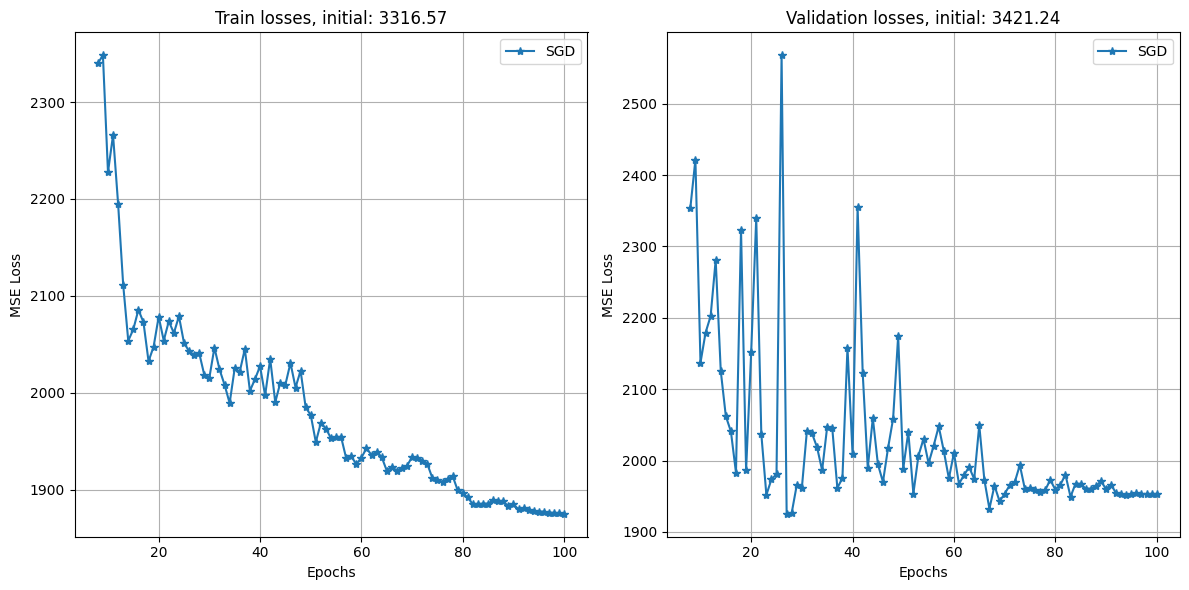

In [24]:
import matplotlib.pyplot as plt


def plot_dictionaries(dict1, dict2, initial_train, initial_val, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Plot for dictionary 1
    for key, values in dict1.items():
        axes[0].plot(
            range(8, len(values) + 1), values[7:], label=key, marker="*"
        )  # Start from second element
        axes[0].legend()
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("MSE Loss")
        axes[0].set_title(f"Train losses, initial: {initial_train.round(2)}")
        axes[0].grid(True)
    # Plot for dictionary 2
    for key, values in dict2.items():
        axes[1].plot(range(8, len(values) + 1), values[7:], label=key, marker="*")
        axes[1].legend()
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("MSE Loss")
        axes[1].set_title(f"Validation losses, initial: {initial_val.round(2)}")
        axes[1].grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


plot_dictionaries(
    train_loss_dict,
    test_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [35]:
import json

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "w") as json_file:
    json.dump(train_loss_dict, json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "w") as json_file:
    json.dump(test_loss_dict, json_file)

In [37]:
logging.info(
    f"% of variation before training: {(initial_mse_train/(df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(train_loss_dict['SGD'][20]/ (df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation before training: {(initial_mse_val/(df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(test_loss_dict['SGD'][20] / (df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)